# Hyperparameter Tuning using Grid Search

In this notebook, we perform hyperparameter tuning of our neural network model using grid search. The goal is to find the optimal combination of hyperparameters that maximizes model performance on the Iris dataset.


In [23]:
# Import libraries
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# Load environment variables
from dotenv import load_dotenv
load_dotenv()
project_root = os.getenv("PROJECT_ROOT")
if not project_root:
    raise ValueError("PROJECT_ROOT is not set. Please run set_project_root.py.")

# Define data paths
processed_data_path = os.path.join(project_root, 'data', 'processed', 'processed_iris.csv')
processed_scaler_path = os.path.join(project_root, 'data', 'processed', 'scaler.pkl')

# Load the dataset
data = pd.read_csv(processed_data_path)

# Separate features and target
X = data.drop('class', axis=1).values
y = data['class'].values

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [24]:
# Import the NeuralNetwork class
import sys
sys.path.append('../src/model/')
from model import NeuralNetwork

class CustomNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_size, hidden_size=8, output_size=3, learning_rate=0.01, n_epochs=1000, batch_size=32):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.nn = None

    def fit(self, X, y):
        # Initialize the neural network
        self.nn = NeuralNetwork(self.input_size, self.hidden_size, self.output_size)
        
        # One-hot encode labels
        n_classes = self.output_size
        y_one_hot = np.eye(n_classes)[y].T  # Shape: (n_classes, m_samples)
        X_T = X.T  # Transpose features
        
        # Training loop
        for epoch in range(self.n_epochs):
            # Shuffle data
            permutation = np.random.permutation(X_T.shape[1])
            X_shuffled = X_T[:, permutation]
            y_shuffled = y_one_hot[:, permutation]
            
            # Mini-batch gradient descent
            for i in range(0, X_T.shape[1], self.batch_size):
                X_batch = X_shuffled[:, i:i+self.batch_size]
                y_batch = y_shuffled[:, i:i+self.batch_size]
                
                # Forward propagation
                A2, cache = self.nn.forward_propagation(X_batch)
                
                # Backward propagation
                gradients = self.nn.backpropagation(X_batch, y_batch, cache)
                
                # Update parameters
                self.nn.update_parameters(gradients, self.learning_rate)
        return self

    def predict(self, X):
        X_T = X.T
        predictions = self.nn.predict(X_T)
        return predictions


In [ ]:
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 1],
    'n_epochs': range(5_000, 10_000, 1000),
    'hidden_size': range(3, 11),
    'batch_size': [8, 16, 32, 64]
}

In [26]:
# Initialize the custom classifier
input_size = X_train.shape[1]
output_size = len(np.unique(y))
nn_classifier = CustomNNClassifier(input_size=input_size, output_size=output_size)

# Set up the cross-validation strategy
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=nn_classifier, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

# Run the grid search
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 640 candidates, totalling 1920 fits


/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/User

[CV] END batch_size=8, hidden_size=3, learning_rate=0.001, n_epochs=5000; total time=   1.7s
[CV] END batch_size=8, hidden_size=3, learning_rate=0.001, n_epochs=5000; total time=   1.7s
[CV] END batch_size=8, hidden_size=3, learning_rate=0.001, n_epochs=5000; total time=   1.8s


/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/User

[CV] END batch_size=8, hidden_size=3, learning_rate=0.001, n_epochs=6000; total time=   2.0s
[CV] END batch_size=8, hidden_size=3, learning_rate=0.001, n_epochs=6000; total time=   2.1s


/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/User

[CV] END batch_size=8, hidden_size=3, learning_rate=0.001, n_epochs=6000; total time=   2.2s
[CV] END batch_size=8, hidden_size=3, learning_rate=0.001, n_epochs=7000; total time=   2.4s


/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/User

[CV] END batch_size=8, hidden_size=3, learning_rate=0.001, n_epochs=7000; total time=   2.5s


/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/User

[CV] END batch_size=8, hidden_size=3, learning_rate=0.001, n_epochs=7000; total time=   2.7s
[CV] END batch_size=8, hidden_size=3, learning_rate=0.001, n_epochs=8000; total time=   2.9s
[CV] END batch_size=8, hidden_size=3, learning_rate=0.01, n_epochs=5000; total time=   1.9s
[CV] END batch_size=8, hidden_size=3, learning_rate=0.01, n_epochs=5000; total time=   1.8s
[CV] END batch_size=8, hidden_size=3, learning_rate=0.01, n_epochs=5000; total time=   1.8s
[CV] END batch_size=8, hidden_size=3, learning_rate=0.001, n_epochs=8000; total time=   2.8s
[CV] END batch_size=8, hidden_size=3, learning_rate=0.001, n_epochs=8000; total time=   3.0s
[CV] END batch_size=8, hidden_size=3, learning_rate=0.01, n_epochs=6000; total time=   2.0s
[CV] END batch_size=8, hidden_size=3, learning_rate=0.01, n_epochs=6000; total time=   2.3s
[CV] END batch_size=8, hidden_size=3, learning_rate=0.001, n_epochs=9000; total time=   3.4s
[CV] END batch_size=8, hidden_size=3, learning_rate=0.001, n_epochs=9000; t

/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/jacob/miniconda3/envs/iris/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan na

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=CustomNNClassifier(input_size=4), n_jobs=-1,
             param_grid={'batch_size': [8, 16, 32, 64],
                         'hidden_size': range(3, 11),
                         'learning_rate': [0.001, 0.01, 0.1, 1],
                         'n_epochs': range(5000, 10000, 1000)},
             scoring='accuracy', verbose=2)

In [27]:
# Best parameters
print("Best Parameters:")
print(grid_search.best_params_)

# Best score
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# Results dataframe
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by='rank_test_score')
results_df.head()


Best Parameters:
{'batch_size': 8, 'hidden_size': 3, 'learning_rate': 0.001, 'n_epochs': 5000}
Best Cross-Validation Accuracy: nan


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_hidden_size,param_learning_rate,param_n_epochs,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.721201,0.032816,0.002538,0.001434,8,3,0.001,5000,"{'batch_size': 8, 'hidden_size': 3, 'learning_...",NaN,NaN,NaN,NaN,NaN,1
422,0.826982,0.016676,0.000575,0.000017,32,8,0.001,7000,"{'batch_size': 32, 'hidden_size': 8, 'learning...",NaN,NaN,NaN,NaN,NaN,1
423,0.957101,0.016954,0.000594,0.000006,32,8,0.001,8000,"{'batch_size': 32, 'hidden_size': 8, 'learning...",NaN,NaN,NaN,NaN,NaN,1
424,1.037267,0.025877,0.001004,0.000492,32,8,0.001,9000,"{'batch_size': 32, 'hidden_size': 8, 'learning...",NaN,NaN,NaN,NaN,NaN,1
425,0.629870,0.058008,0.000576,0.000020,32,8,0.010,5000,"{'batch_size': 32, 'hidden_size': 8, 'learning...",NaN,NaN,NaN,NaN,NaN,1


Test Accuracy: 0.9667

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



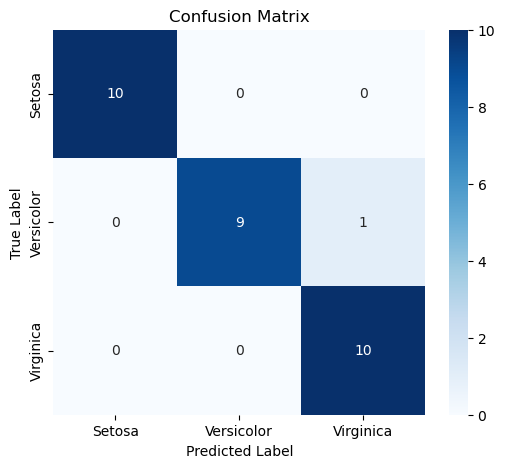

In [28]:
# Get the best estimator
best_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Setosa', 'Versicolor', 'Virginica'],
            yticklabels=['Setosa', 'Versicolor', 'Virginica'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## Conclusion

- The grid search identified the best hyperparameters as:
  - *Hidden Size*: `X`
  - *Learning Rate*: `Y`
  - *Number of Epochs*: `Z`
  - *Batch Size*: `W`
- The best cross-validation accuracy achieved was `A%`.
- The test accuracy of the best model is `B%`.
- The confusion matrix indicates that the model performs well in classifying all three species, with minor misclassifications between *Iris Versicolor* and *Iris Virginica*.
